In [1]:
include("../LiPoSID.jl")

using LinearAlgebra

using DynamicPolynomials

using SymPy

using Plots

function ⊗(A::AbstractMatrix, B::AbstractMatrix)
    return kron(A,B)
end

function LME_operator_symbolic(H, J)
    
    Id = I(2)   
    U = -im*(Id ⊗ H - transpose(H) ⊗ Id)
    D = sum( 2*transpose(j')⊗j-Id⊗(j'*j) - transpose(j)*transpose(j')⊗Id for j in J )/2 
    
    Lᴸᴹᴱ = U + D
    
    return Lᴸᴹᴱ
end

#=
function SumCoeffs2(poly, s)
    p = SymPy.collect(SymPy.expand(poly),s)
    degrees = range(0,convert(Int32,SymPy.degree(p, s)))
    obj = sum(p.coeff(s^i)^2 for i in degrees)
    return obj
end
=#

function SumCoeffs2(poly, s)
    p = SymPy.expand(poly)
    rest_poly = SymPy.subs(p, s => 0)
    degrees = range(1,convert(Int32,SymPy.degree(p, s)))
    
    obj = rest_poly^2 + sum(p.coeff(s^i)^2 for i in degrees)  
    
    return obj
end 

function sympy_to_dynamicpoly(sympy_expr::Sym) #
    # Extract variables from the SymPy expression
    vars = free_symbols(sympy_expr)

    # Convert SymPy variables to string and then to Symbol
    var_symbols = [Symbol(string(v)) for v in vars]

    # Create DynamicPolynomials variables using @polyvar macro
    @eval begin
        @polyvar $(var_symbols...)
    end

    # Map SymPy variables to DynamicPolynomials variables
    var_map = Dict(vars[i] => eval(var_symbols[i]) for i in 1:length(vars))

    # Substitute using subs and convert to DynamicPolynomial
    dynamic_poly_expr = SymPy.subs(sympy_expr, var_map)
    dynamic_poly = eval(Meta.parse(string(dynamic_poly_expr)))
    return dynamic_poly
end

bˣ = [1, 0, 0, 1]

function TF_objective(Aˢʸᵐᵇ, Aˢⁱᵈ, b)

    @syms s

    Gˢʸᵐᵇ = inv(I(4)*s - Aˢʸᵐᵇ)*b

    Gˢⁱᵈ = inv(I(4)*s - Aˢⁱᵈ)*b

    ΔG = SymPy.together.(Gˢʸᵐᵇ[1:3] - Gˢⁱᵈ[1:3])

    polys = SymPy.numerator.(ΔG)

    obj = sum(SumCoeffs2.(polys, s)) #.^2

    #objective = sympy_to_dynamicpoly(obj.subs(s,0))

    return obj

end

TF_objective (generic function with 1 method)

In [2]:
ω = SymPy.symbols("ω", real=true)
γ = SymPy.symbols("γ", real=true)

Hᴸᴹᴱ = [ ω        0
         0        0   ]


Jᴸᴹᴱ = [ 0     γ
         0     0. + 0im  ]

Lᴸᴹᴱ = LME_operator_symbolic(Hᴸᴹᴱ, [Jᴸᴹᴱ])

M =   [ 0  0    1  1
        1  -im  0  0 
        1  im   0  0
        0  0   -1  1 ]/2

Aᴸᴹᴱ = real.(inv(M) * Lᴸᴹᴱ * M)



4×4 Matrix{Sym{PyCall.PyObject}}:
 -0.5*γ^2     1.0⋅ω         0        0
   -1.0⋅ω  -0.5*γ^2         0        0
        0         0  -1.0*γ^2  1.0*γ^2
        0         0         0        0

In [3]:
γ2ₜₛₜ = 1 #4π/2
ωₜₛₜ = 25

Aˢⁱᵈ = [  0    -ωₜₛₜ   0      0 
          ωₜₛₜ -γ2ₜₛₜ   0      0
          0     0     -γ2ₜₛₜ   γ2ₜₛₜ
          0     0      0      0    ]

obj = TF_objective(Aᴸᴹᴱ, Aˢⁱᵈ, bˣ)

#best_solution, best_method = LiPoSID.sos_min_newton(objective) 

objective = sympy_to_dynamicpoly(obj)


39.1875γ⁸ - 156.0γ⁶ + 313.5γ⁴ω² + 7812.5γ⁴ω + 97970.25γ⁴ - 624.0γ²ω² + 627.0ω⁴ + 50.0γ²ω + 31250.0ω³ - 627.0γ² + 389377.0ω² + 50.0ω + 391251.0

In [4]:
variables(objective)

2-element Vector{PolyVar{true}}:
 γ
 ω

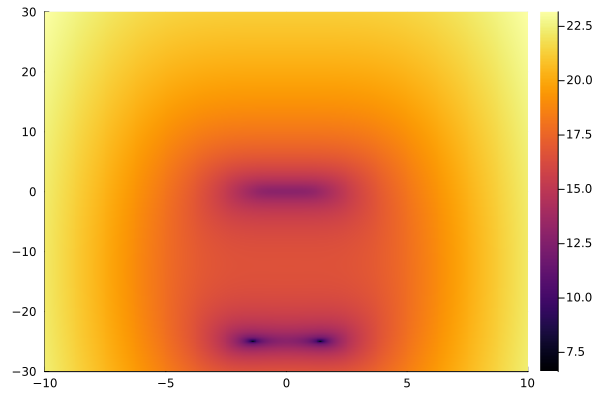

In [5]:
function f(γ_val, ω_val)
    return objective(variables(objective)[1] => γ_val, variables(objective)[2] => ω_val)
end

w = range(-30, 30, length=1000)
#g = range(-3*γᶠ, 3*γᶠ, length=500)
g = range(-10, 10, length=500)
z = @. f(g', w)

heatmap(g, w, log.(z))

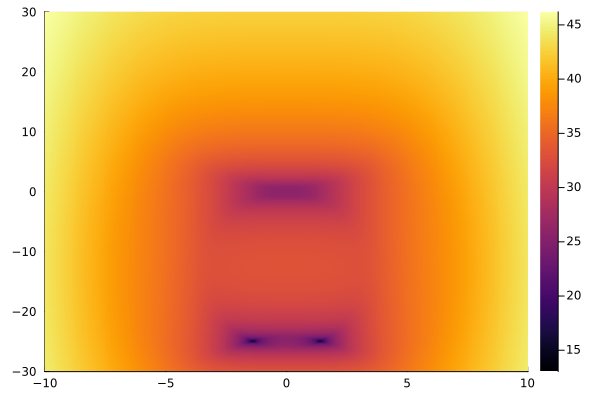

In [72]:
function f(γ_val, ω_val)
    return objective(variables(objective)[1] => γ_val, variables(objective)[2] => ω_val)
end

w = range(-30, 30, length=1000)
#g = range(-3*γᶠ, 3*γᶠ, length=500)
g = range(-10, 10, length=500)
z = @. f(g', w)

heatmap(g, w, log.(z))

In [6]:
f(0, 0)

391251.0

In [9]:
f(-1,-25)


97852.4375

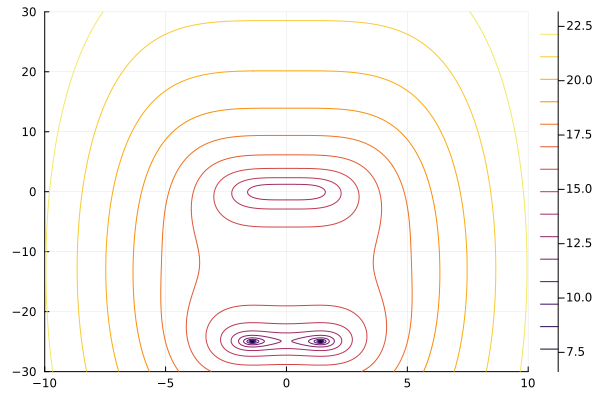

In [8]:
contour(g, w, log.(z))

In [10]:
best_solution, best_method = LiPoSID.sos_min_newton(objective)

*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...


optimum = 621.0144048554318



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Found a locally optimal solution by Ipopt, giving an upper bound: 391249.99518966.
The relative optimality gap is: 99.841274%.
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************


Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = 621.0143909861512
Found a locally optimal solution by Ipopt, giving an upper bound: 391249.99518969.
The relative optimality gap is: 99.841274%.
No higher TS step of the TSSOS hierarchy!


val_p = [391249.9951896612, 391249.99518969224]


(PolyVar{true}[γ, ω] => [-0.0565686165303286, -6.451414472555889e-5], "tssos")

In [77]:
minimum(coefficients(objective))

-9.703025e8

In [78]:
maximum(coefficients(objective))

1.52602739381e11

In [79]:
objective /minimum(coefficients(objective))

-1.5726047740266567e-6γ¹⁶ + 6.025826997250858e-8γ¹⁴ - 2.5161676384426507e-5γ¹²ω² - 0.0006290322476753384γ¹²ω - 0.00016322673856864226γ¹² + 7.230992396701029e-7γ¹⁰ω² - 0.00015097005830655904γ⁸ω⁴ - 8.051612770244332e-6γ¹⁰ω - 0.007548386972104062γ⁸ω³ + 0.03115072309923967γ¹⁰ - 0.0956604900275945γ⁸ω² + 2.8923969586804116e-6γ⁶ω⁴ - 0.0004025868221508241γ⁴ω⁶ - 0.02015318676392156γ⁸ω - 6.441290216195466e-5γ⁶ω³ - 0.030193547888416244γ⁴ω⁵ - 9.704783714163883γ⁸ + 0.12218837475941781γ⁶ω² - 0.7574490367694612γ⁴ω⁴ + 3.856529278240549e-6γ²ω⁶ - 0.0004025868221508241ω⁸ - 9.661935324293197e-5γ⁶ω - 6.371031868927473γ⁴ω³ - 0.00012882580432390932γ²ω⁵ - 0.04025806385122166ω⁷ + 0.5020190265406922γ⁶ - 0.5132928906191625γ⁴ω² - 0.00965807055016348γ²ω⁴ - 1.509674817904726ω⁶ - 0.060515921581156394γ⁴ω - 0.0807740884930215γ²ω³ - 25.16167648748715ω⁵ - 156.7574529010283γ⁴ + γ²ω² - 157.27336514231388ω⁴ - 0.0001288258043239093γ²ω - 0.16109697748897894ω³ + 0.5032258022626964γ² - 6.4412902161954644e-6ω² - 6.4412902161954

In [80]:
function coef_range(p)
    maximum(coefficients(p))/minimum(coefficients(p))
end

coef_range(objective)

-157.27336514231388

In [81]:
best_solution, best_method = LiPoSID.sos_min_newton(objective /minimum(coefficients(objective))) 

*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
termination status: INFEASIBLE
solution status: NO_SOLUTION
optimum = -0.01567863059453655
Found a locally optimal solution by Ipopt, giving an upper bound: -240048.87284885.
The relative optimality gap is: 99.999993%.
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
termination status: INFEASIBLE
solution status: NO_SOLUTION
optimum = -4.10701603507207
The local solver failed refining the solution!
No higher TS step of the TSSOS hierarchy!
val_p = [-240048.87284884587, -988232.4649017054]


(PolyVar{true}[γ, ω] => [4.228392776902956, -1.0708123520491695], "scaled_tssos")